# 20Newsgroup documents

## Introduction

In this notebook, we will demonstrate use on the 20Newsgroup data. Each document is associated with 1 of 20 newsgroup topics, organized at two
hierarchical levels.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import pyemb as eb

## Data load

Import data and create dataframe.

In [2]:
newsgroups = fetch_20newsgroups() 

df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(
    lambda row: newsgroups["target_names"][row])
df[['layer1', 'layer2']] = df['target_names'].str.split('.', n=1, expand=True)

In [3]:
df.head()

,data,target,target_names,layer1,layer2
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,rec,autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,comp,graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,sci,space


For a random sample of the data, create tf-idf features.

In [4]:
n = 5000
df = df.sample(n=n, replace=False, random_state=22).reset_index(drop=True)

`eb.text_matrix_and_attributes' - creates a Y matrix of tf-idf features. It takes in a dataframe and the column which contains the data. Further functionality includes: removing general stopwords, adding stopwords, removing email addresses, cleaning (lemmatize and remove symbol, lowercase letters) and a threshold for the min/max number of documents a word needs to appear in to be included.

In [5]:
Y, attributes = eb.text_matrix_and_attributes(df, 'data', remove_stopwords=True, clean_text=True,
                                    remove_email_addresses=True, update_stopwords=['subject'],
                                    min_df=5, max_df=len(df)-1000)

In [6]:
(n,p) = Y.shape
print("n = {}, p = {}".format(n,p))

n = 5000, p = 12804


Perform dimension selection using Wasserstein distances, see [1] for details

In [7]:
ws, dim = eb.wasserstein_dimension_select(Y, range(40), split=0.5)

100%|██████████| 40/40 [02:29<00:00,  3.75s/it]

Recommended dimension: 27, Wasserstein distance 0.97249


In [8]:
print("Selected dimension: {}".format(dim))

Selected dimension: 27


## PCA and tSNE

Now we perform PCA [1].

In [9]:
zeta = p**-.5 * eb.embed(Y, d=dim, version='full')

Apply t-SNE

In [10]:
from sklearn.manifold import TSNE

tsne_zeta = TSNE(n_components=2, perplexity=30).fit_transform(zeta)

Make dataframes of PCA embedding and t-SNE embedding for plotting

In [11]:
zeta_df = pd.DataFrame(zeta[:, :2])
zeta_df["target"] = np.array(df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)
labels = df['target']

tsne_zeta_df = pd.DataFrame(tsne_zeta)
tsne_zeta_df["target"] = np.array(df['target_names'])
targets = tsne_zeta_df["target"].unique()
targets = sorted(targets)

Colours dictionary where topics from the same theme have different shades of the same colour

In [12]:
target_colour = {'alt.atheism': 'goldenrod',
                 'comp.graphics': 'steelblue',
                 'comp.os.ms-windows.misc': 'skyblue',
                 'comp.sys.ibm.pc.hardware': 'lightblue',
                 'comp.sys.mac.hardware': 'powderblue',
                 'comp.windows.x': 'deepskyblue',
                 'misc.forsale': 'maroon',
                 'rec.autos': 'limegreen',
                 'rec.motorcycles': 'green',
                 'rec.sport.baseball': 'yellowgreen',
                 'rec.sport.hockey': 'olivedrab',
                 'sci.crypt': 'pink',
                 'sci.electronics': 'plum',
                 'sci.med': 'orchid',
                 'sci.space': 'palevioletred',
                 'soc.religion.christian': 'darkgoldenrod',
                 'talk.politics.guns': 'coral',
                 'talk.politics.mideast': 'tomato',
                 'talk.politics.misc': 'darksalmon',
                 'talk.religion.misc': 'gold'}

Plot PCA on the LHS and PCA + t-SNE on the RHS

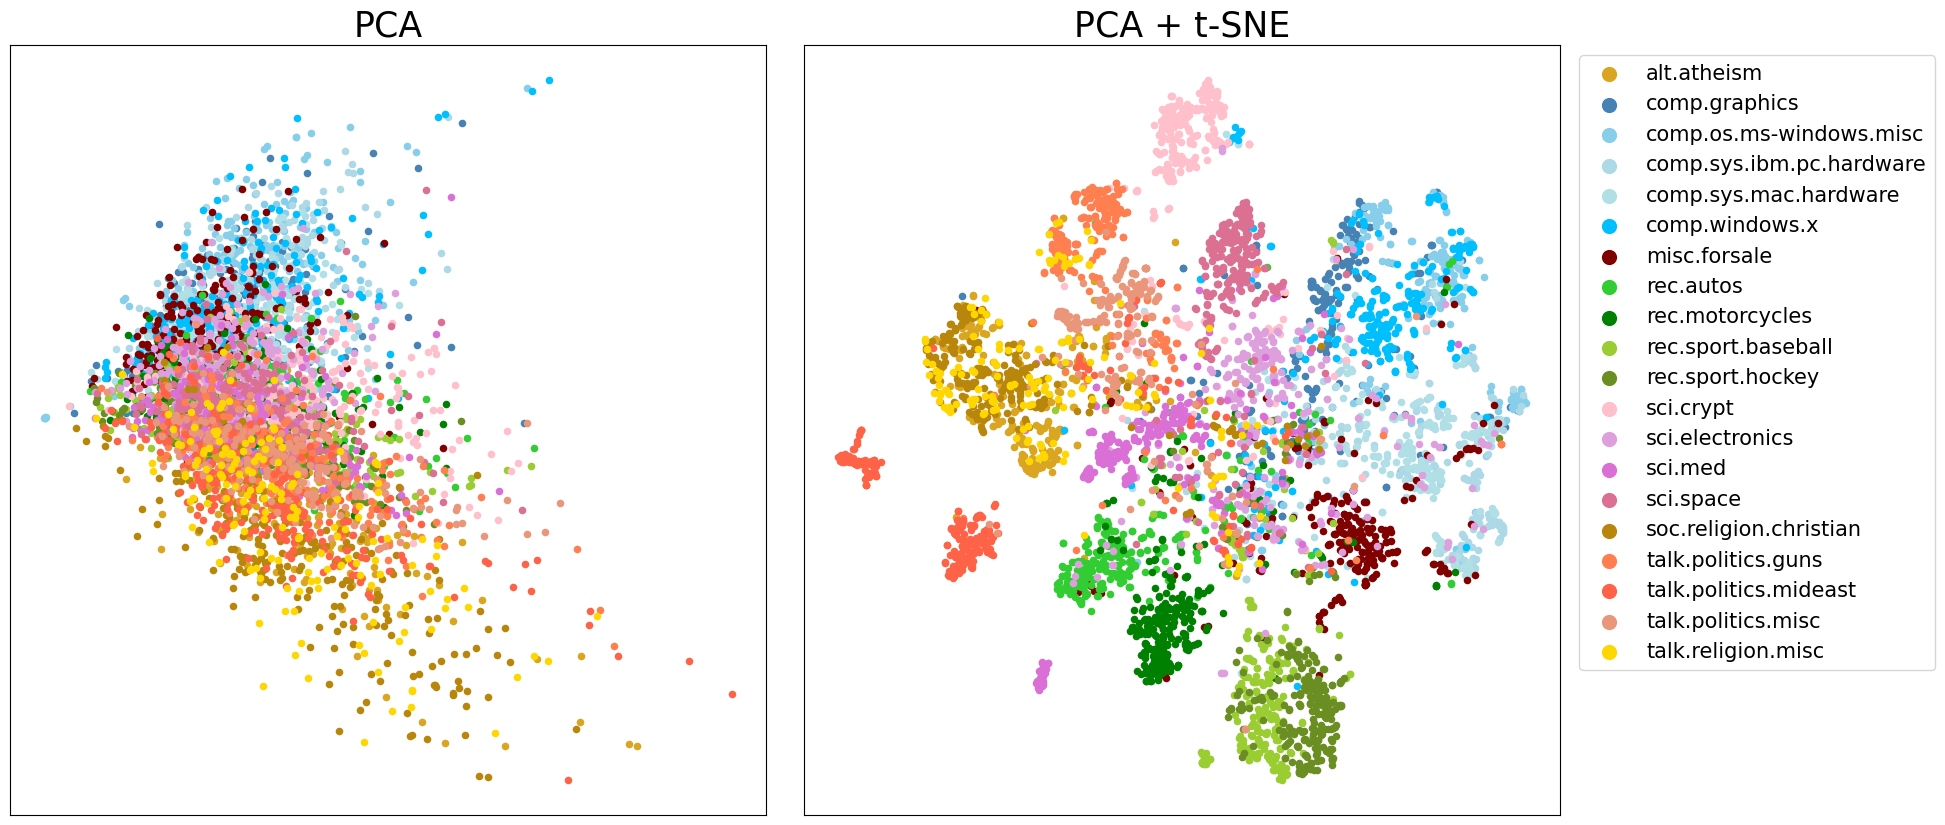

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax[0].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, c=target_colour[t])
ax[0].set_title(f'PCA', fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)

for t in targets:
    t_df = tsne_zeta_df[tsne_zeta_df['target'] == t]
    ax[1].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, alpha=1, c=target_colour[t])
ax[1].set_title(f'PCA + t-SNE', fontsize=25)
ax[1].legend(loc='upper right', bbox_to_anchor=(
    1.51, 1), prop={'size': 15}, markerscale=2)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0)

## Hierarchical clustering with dot products [2]

First we do this for the centroids of each topic and plot the dendrogram. Then we do HC on the whole dataset and visualise the output tree. 

## On centroids

Find centroids

In [15]:
idxs = [np.where(np.array(df['target']) == t)[0]
        for t in sorted(df['target'].unique())]
t_zeta = np.array([np.mean(zeta[idx, :], axis=0) for idx in idxs])
t_Y = np.array([np.mean(Y[idx, :],axis = 0) for idx in idxs]).reshape(len(sorted(df['target'].unique())),p)

Topic HC clustering

In [16]:
t_dp_hc = eb.DotProductAgglomerativeClustering()
t_dp_hc.fit(t_zeta);

Plot dendrogram

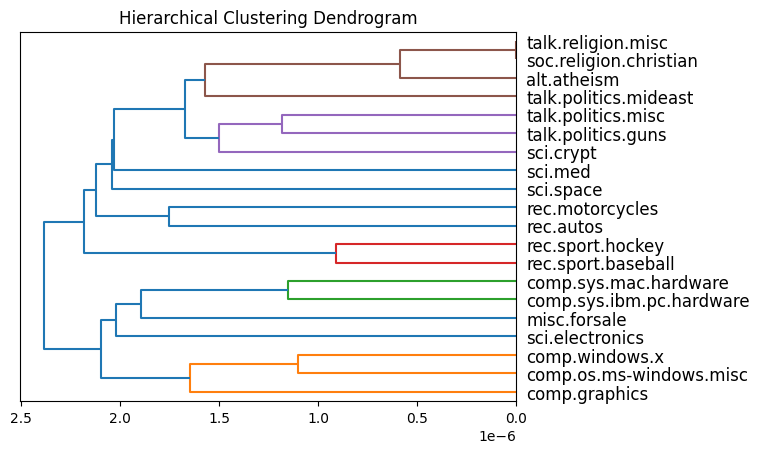

In [17]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
eb.plot_dendrogram(t_dp_hc, dot_product_clustering=True, orientation='left',
                   labels=sorted(df['target_names'].unique()))
plt.show()

## On documents

In [18]:
dp_hc = eb.DotProductAgglomerativeClustering()
dp_hc.fit(zeta);

Use construct tree graph from hierarchical clustering, epsilon is set to zero as we don't want to prune the tree 

In [19]:
tree = eb.ConstructTree(model= dp_hc, epsilon=0)
tree.fit()

Constructing tree...


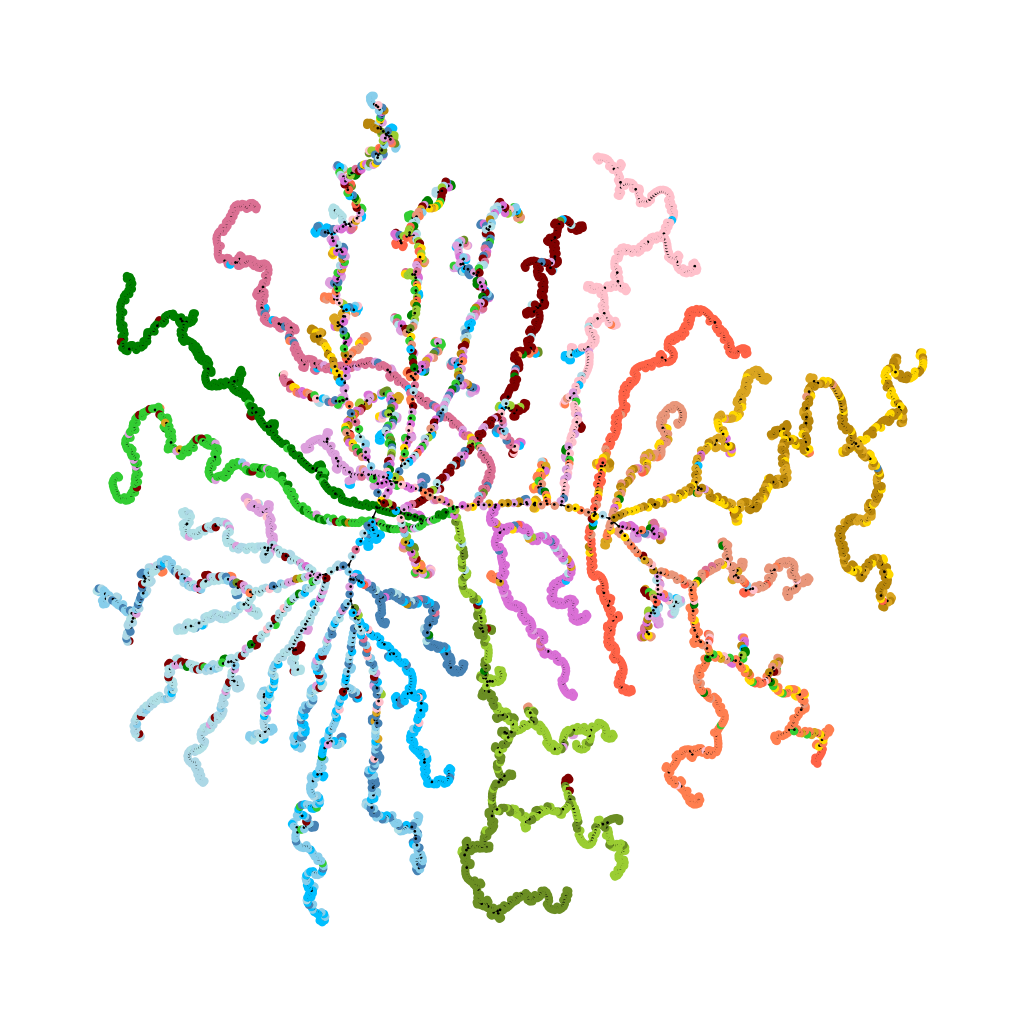

In [20]:
tree.plot(labels = list(df["target_names"]), colours = target_colour, node_size=25, forceatlas_iter=0)

## References


[1]: Whiteley, N., Gray, A. and Rubin-Delanchy, P., 2022. Statistical exploration of the Manifold Hypothesis. arXiv preprint arXiv:2208.11665.

[2]: Gray, A., Modell, A., Rubin-Delanchy, P. and Whiteley, N., 2024. Hierarchical clustering with dot products recovers hidden tree structure. Advances in Neural Information Processing Systems, 36.